### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
from logging import lastResort

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [2]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data: pd.DataFrame = pd.read_csv(train_file_path, delimiter=',')
test_data: pd.DataFrame = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


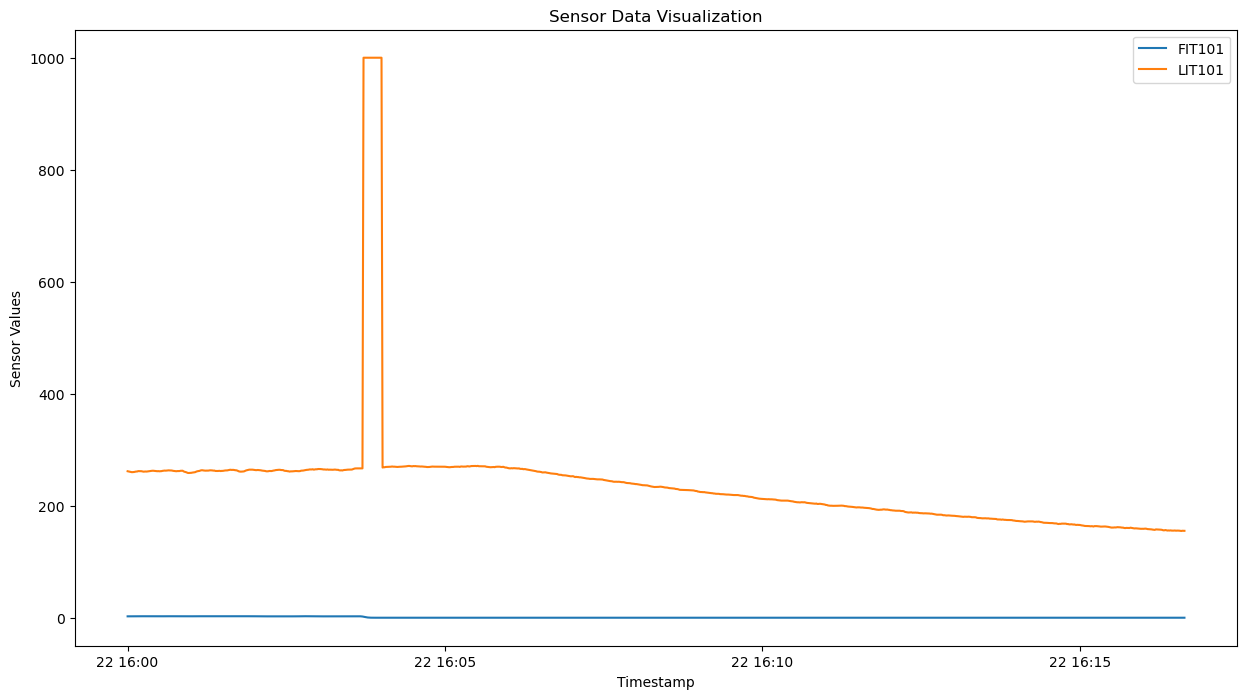

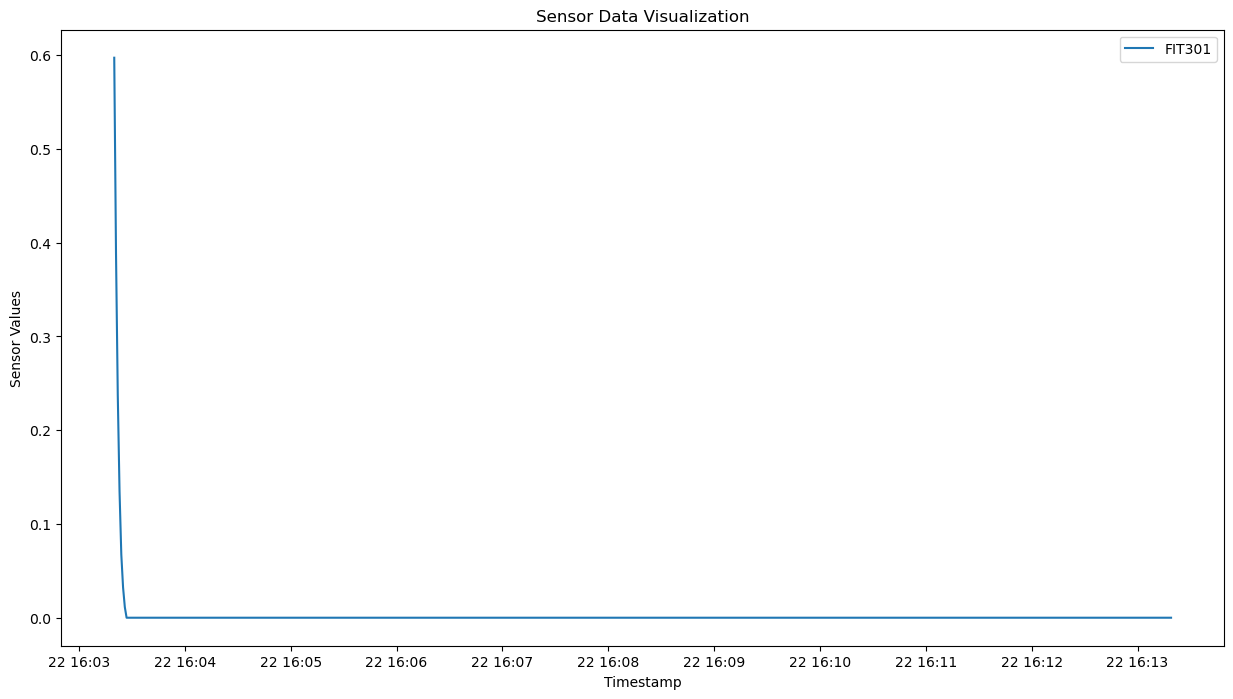

In [3]:
def visualize_sensor_data(df: pd.DataFrame, window: (int, int) = None, sensors: list[str] = None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
#visualize_sensor_data(train_data)

Below are the implementations for DTW and PCA functions

In [4]:
def dynamic_time_warping(a: np.ndarray, b: np.ndarray) -> float:
    n = len(a)
    m = len(b)

    dist = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist[i][j] = (b[j]-a[i])**2
    for i in range(1,n):
        dist[i][0] += dist[i-1][0]
    for j in range(1,m):
        dist[0][j] += dist[0][j-1]
    for i in range(1,n):
        for j in range(1,m):
            dist[i][j] += min(dist[i-1][j-1], dist[i-1][j], dist[i][j-1])

    return float(np.sqrt(dist[n-1][m-1]))

In [5]:
def norm(x: np.ndarray) -> np.ndarray:
    return x - np.mean(x, axis=0)

def principal_component_analysis(df: pd.DataFrame, k: int) -> np.ndarray:
    x = norm(np.array(df))
    _, evecs = np.linalg.eigh(np.cov(x.T))
    return evecs[:, :-k:-1]

def apply_principal_component_analysis(df: pd.DataFrame, eigenvectors: np.ndarray) -> pd.DataFrame:
    return pd.DataFrame(norm(np.array(df)) @ eigenvectors)

We will plot two windows of the graphs, which are 70 minutes apart, to support our next hypotheses.

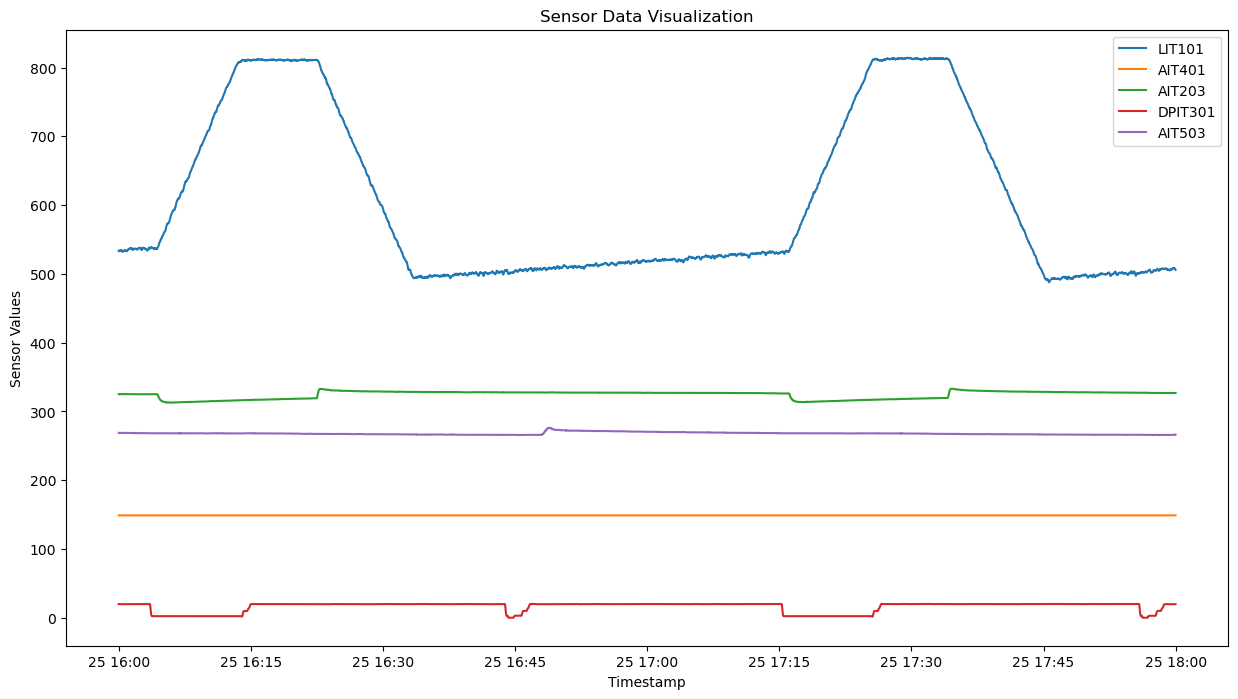

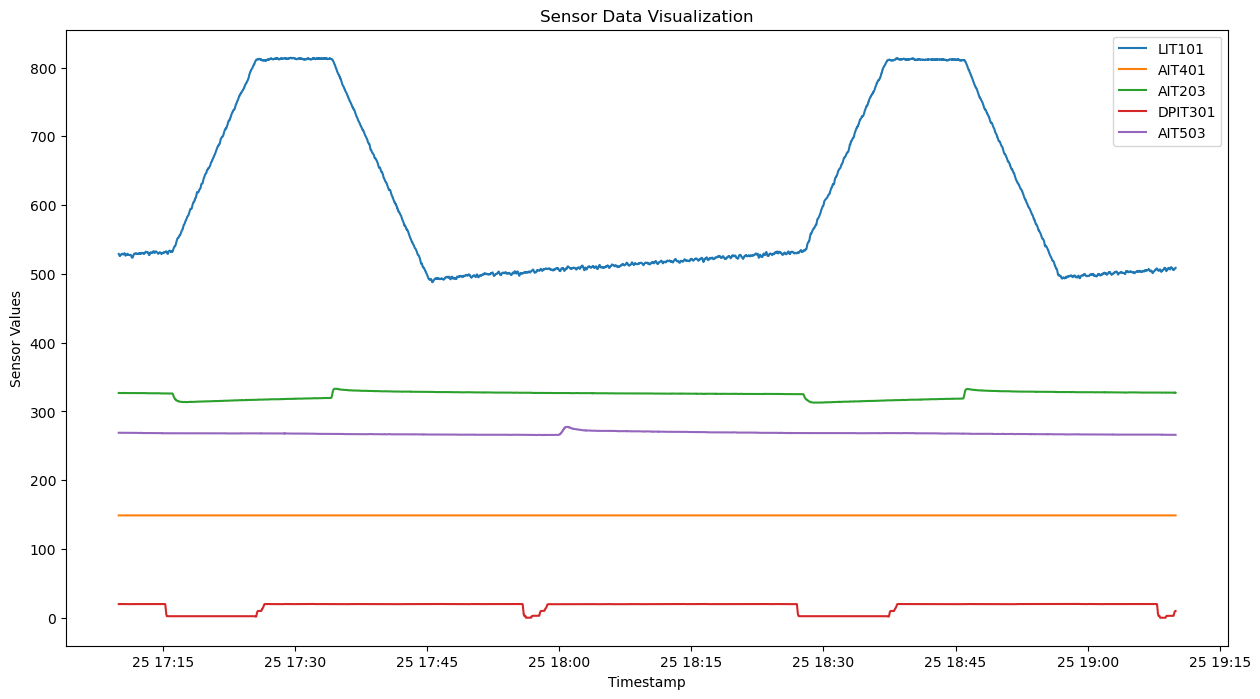

In [6]:
sday, shour, smin, ssec = 3, 0, 0, 0
eday, ehour, emin, esec = 3, 2, 0, 0
start = 86400*sday + 3600*shour + 60*smin + ssec
end = 86400*eday + 3600*ehour + 60*emin + esec
visualize_sensor_data(train_data, window = (start, end), sensors=['LIT101', 'AIT401', 'AIT203', 'DPIT301', 'AIT503'])
visualize_sensor_data(train_data, window = (start+4200, end+4200), sensors=['LIT101', 'AIT401', 'AIT203', 'DPIT301', 'AIT503'])

### Familiarization
1. What types of signals are there?
2. Are the signals correlated? Do they show cyclic behavior?

These signals are measured each second, over the course of a few days. Many of them seem to exhibit periodic behavior. Specifically, starting one day after the measuring began, signals such as LIT101, AIT203 and DPIT301 have periods of about 70 minutes. They all seem correlated in this sense.

We will consider the signal LIT101. We sample a few windows from the train data, then as many windows from the test data as we can without it being too slow, and for each test window, we take the minimum DTW distance to all train windows as its anomaly score. We normalize the data first. The parameters (window size, slide) were chosen mostly so that it wouldn't take ridiculously long, which can very easily happen.

- What kind of anomalies do you expect to detect using DTW distances in this manner?

We expect to detect regions of the examined signal that are not similar to any of the sampled regions from the train set. With this technique at least, it seems impractical to check individual points from the examined signal, because it would be too slow. The best we can do now is find approximate regions that contain anomalies.

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view as sld_win

winsize = 400 # bigger windows = probably more accurate, but much slower
trainslide = 50000 # bigger slide = fewer windows taken, faster; we only sample the train set so we can take relatively few
trainsig = np.array(train_data['LIT101'])
trainsig = (trainsig - np.mean(trainsig)) / np.std(trainsig)
windows = sld_win(trainsig, winsize)[::trainslide]

#warp only one test window against all train windows
def warp(data: np.ndarray) -> float:
    mindist = 10000000
    for w in windows:
        mindist = min(mindist, dynamic_time_warping(data, w))
    return mindist

def warp_all(data: np.ndarray) -> list[float]:
    dists = []
    for w in data:
        dists.append(warp(w))
    return dists

In [8]:
testslide = 2000 # more windows because we want to check as many places in the test set as we can
times = sld_win(test_data['Timestamp'], winsize)[::testslide, 0] # one representative timestamp for each window to plot with
testsig = np.array(test_data['LIT101'])
testsig = (testsig - np.mean(testsig)) / np.std(testsig)
test_windows = sld_win(testsig, winsize)[::testslide]
dists = warp_all(test_windows)
print(dists)

[0.15482809084327911, 18.513573433842463, 3.1286741099270863, 8.725928754194156, 5.782607836846567, 11.641635838434077, 1.099591094744147, 2.540365373187026, 1.22606212629158, 2.204960738878172, 1.457924528660719, 2.377905328393779, 0.6940400343710444, 18.060059638044876, 0.19460151854264307, 17.37545433270145, 4.08572332235074, 0.11173787338897537, 1.7120307183709331, 1.9138956254019028, 1.2644394240514014, 10.83363006868522, 0.22186735291098394, 16.262504846654736, 0.8090947652990933, 11.916689721109082, 1.9338422689305697, 1.1217391100162963, 2.8535758674480274, 1.5515813120010797, 4.061778205163249, 0.18932914531340522, 4.534822150331499, 0.09013760485398004, 17.691573640313617, 0.5561572968913889, 13.317531820278248, 1.468323666023858, 11.780269252551722, 1.7494665375989973, 3.9123378067549095, 2.5517901826442495, 0.43455427537705305, 3.496491214549818, 2.193608496550235, 4.077363665333939, 0.16385442728327038, 4.060002764753772, 0.13138160666052412, 4.953325371009129, 0.121253767

Now it is time to pick a threshold for the distance above which we consider an anomaly. After trying out a few different values, it seems reasonable to pick a threshold of 2 standard deviations above the mean distance.

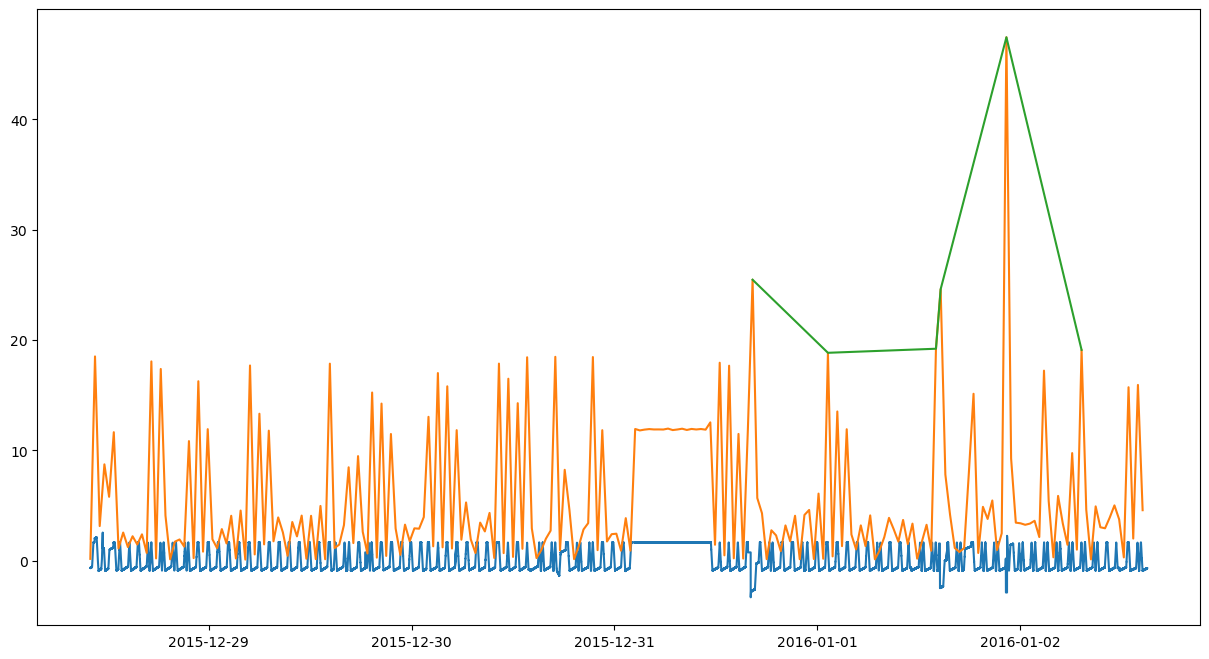

['2015-12-31T16:20:00.000000000' '2016-01-01T01:14:41.000000000'
 '2016-01-01T14:01:21.000000000' '2016-01-01T14:34:41.000000000'
 '2016-01-01T22:21:21.000000000' '2016-01-02T07:14:41.000000000']


In [9]:
threshold = np.mean(dists) + 2 * np.std(dists)
dists = np.array(dists)
plt.figure(figsize=(15, 8))
plt.plot(test_data['Timestamp'][:], testsig)
plt.plot(times, dists)
above = np.where(dists > threshold)
plt.plot(times[above], dists[above])
plt.show()
print(times[above])

It picks out the 3 obvious anomalies towards the end of the graph (the dips), though it also picks some that are not very anomalous, while also ignoring the flat section in the middle. To detect that, we would probably need larger windows (which would take too long), or maybe the train signal has a relatively flat section (such as the one towards the beginning) which makes the algorithm think that is normal. On this test set, it detects anomalies in 6 places.